In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


In [2]:
# obj <- readRDS('/data/srlab2/ik936/Roche/data/cache/mouse_query_joint.rds')

In [3]:
# dname <- '/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/'
# if (!dir.exists(dname)) dir.create(dname)
# obj %>% imap(function(.obj, .name) {
#     message(.name)
#     saveRDS(.obj, paste0(dname, .name, '.rds'))
#     return(.name)
# })


In [4]:
dname <- '/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/'
# fields_load <- c('meta_data', 'effects_hs', 'U', 'masc')
fields_load <- c('meta_data', 'effects_hs', 'presto_hs', 'U', 'masc')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [5]:
obj$meta_data <- obj$meta_data %>% 
#     dplyr::mutate(Tissue = factor(Tissue, c('Synovium', 'Gut', 'Lung')))
    dplyr::mutate(Tissue = factor(Tissue, c('Synovium_cia', 'Synovium_sta', 'Gut', 'Lung'))) 


obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(LibraryID = case_when(
        Tissue == 'Synovium' ~ Status_tissue, 
        LibraryID == 'GSM3891612' ~ 'Bleo1',
        LibraryID == 'GSM3891613' ~ 'Bleo2',
        LibraryID == 'GSM3891616' ~ 'HL1',
        LibraryID == 'GSM3891617' ~ 'HL2',
        TRUE ~ LibraryID
    ))


In [6]:
contrasts_mat <- make_contrast.presto(obj$presto_hs, 'Cluster', 'Tissue')
obj$effects_hs <- contrasts.presto(obj$presto_hs, contrasts_mat, one_tailed = FALSE) %>% 
    tidyr::separate(contrast, c('Cluster', 'Tissue'), sep = '\\|', remove = FALSE) %>% 
    arrange(pvalue)


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 14 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14].”


In [7]:
effects_ref_marginal <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_marginal.rds')
effects_ref_nested <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds')


Nice cluster names

In [8]:
meta_hs <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds') %>% 
    dplyr::select(Cluster, Cluster_name) %>% 
    unique() %>% 
    dplyr::mutate(Cluster = paste0('C', Cluster))


In [9]:
# ## time series analysis 
# tc_enrich <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_time_enrichment.rds')
# tc_meta <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_time_meta.rds')
# tc_expression <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_time_expression.rds')


In [10]:
enrich_res <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_enrich_res.rds')
meta_data <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/metadata.rds') %>% data.frame()
genes_dynamic_pos <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_genes_dynamic_pos.rds')
lres_dynamic <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_lres_dynamics.rds')
lres_peaks <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_lres_peaks.rds')
logcpm <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/logcpm.rds')
hres <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_hres.rds')

# UMAP (lineage) 

## Gather data 

In [11]:
gut_mm <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_obj_mouse_stromal.rds')
gut_mm$meta_data <- gut_mm$meta_data 

gut_mm$exprs_raw <- gut_mm$exprs_raw[, gut_mm$meta_data$CellID]
gut_mm$exprs_raw_hs <- gut_mm$exprs_raw_hs[, gut_mm$meta_data$CellID]


In [12]:
syn_mm <- readRDS('/data/srlab2/ik936/Roche/data/cache/synovium_obj_mouse_stromal.rds')

syn_mm$meta_data <- syn_mm$meta_data %>% 
    dplyr::rename(CellID = cell_id, LibraryID = donor) %>% 
    subset(status == 'case') 

syn_mm$exprs_raw <- syn_mm$exprs_raw[, syn_mm$meta_data$CellID]
syn_mm$exprs_raw_hs <- syn_mm$exprs_raw_hs[, syn_mm$meta_data$CellID]
syn_mm$exprs_norm <- normalizeData(syn_mm$exprs_raw, 1e4, 'log')


In [13]:
head(syn_mm$meta_data)

,CellID,LibraryID,nUMI,nGene,percent_mito,label,status,cell_type,score_notch,label_status,disease
,<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,AAACCTGTCGAACGGA_BRI062,BRI062,4976,1443,0.03758039,WT,case,sublining,39.09332,WT_case,Inflam
3,AAACGGGCAAGTAATG_BRI062,BRI062,5414,1643,0.03472479,WT,case,tcell,12.46428,WT_case,Inflam
4,AAACGGGCACCTATCC_BRI062,BRI062,3169,1184,0.02776901,WT,case,sublining,26.65281,WT_case,Inflam
7,AAACGGGGTTAGGGTG_BRI062,BRI062,8171,2445,0.05629666,WT,case,lining,39.85879,WT_case,Inflam
8,AAACGGGTCTCGATGA_BRI062,BRI062,3750,1377,0.04880000,WT,case,intermediate,32.07274,WT_case,Inflam
9,AAAGATGAGAGGACGG_BRI062,BRI062,3997,1230,0.03002252,WT,case,myeloid,21.27210,WT_case,Inflam


In [14]:
syn_mm_cia <- readRDS('/data/srlab2/ik936/Roche/data/cache/cia2021_obj_mouse.rds')

syn_mm_cia$meta_data <- syn_mm_cia$meta_data %>%
    left_join(tribble(
        ~Name, ~lineage,
        'Endothelial', 'vascular_endothelial',
        'Fibroblast', 'fibroblast',
        'Mural', 'mural',
        'Immune', 'hematopoietic'
    ))


# idx <- which(syn_mm_cia$meta_data$Name == 'Fibroblast')
idx <- which(!is.na(syn_mm_cia$meta_data$lineage))
syn_mm_cia$exprs_raw <- syn_mm_cia$exprs_raw[, idx]
syn_mm_cia$exprs_norm <- syn_mm_cia$exprs_norm[, idx]
syn_mm_cia$exprs_raw_hs <- syn_mm_cia$exprs_raw_hs[, idx]
syn_mm_cia$umap_after <- syn_mm_cia$umap_after$embedding[idx, ]
syn_mm_cia$meta_data <- syn_mm_cia$meta_data[idx, ]

Joining, by = "Name"



In [15]:
lung_mm <- readRDS('/data/srlab2/ik936/Roche/data/cache/lung_obj_mouse_stromal.rds')

lung_mm$meta_data <- lung_mm$meta_data 
#     subset(lineage %in% c('fibroblast', 'myofibroblast')) %>% 
#     subset(FACS == 'GFP+')

idx <- which(lung_mm$meta_data$FACS == 'GFP+')
lung_mm$exprs_raw <- lung_mm$exprs_raw[, idx]
lung_mm$exprs_norm <- lung_mm$exprs_norm[, idx]
lung_mm$exprs_raw_hs <- lung_mm$exprs_raw_hs[, idx]
lung_mm$umap_after <- lung_mm$umap_after[idx, ]
lung_mm$meta_data <- lung_mm$meta_data[idx, ]


In [16]:
meta_mouse <- list(
    Lung = dplyr::select(
        lung_mm$meta_data, 
        CellID, LibraryID, Status = Treatment, Lineage = lineage,
        nGene, nUMI, percent_mito
    ),
    Synovium_sta = dplyr::select(
        syn_mm$meta_data, 
        CellID, LibraryID, Status = label, Lineage = cell_type,
        nGene, nUMI, percent_mito
    ),
    Synovium_cia = dplyr::select(
        syn_mm_cia$meta_data, 
        CellID, LibraryID, Status, Lineage = lineage,
        nGene, nUMI, percent_mito
    ),
    Gut = dplyr::select(
        gut_mm$meta_data, 
        CellID, LibraryID, Status, Lineage = lineage,
        nGene, nUMI, percent_mito
    )
) %>%
    bind_rows(.id = 'Tissue') %>% 
    dplyr::mutate(Status_tissue = case_when(
        Status %in% c('hc', 'Untreated', 'nonInflam', 'Control') ~ 'ctrl',
#         Status %in% c('dss', 'Bleomycin', 'Inflam') ~ 'case'
        TRUE ~ Status
    )) %>% 
    dplyr::mutate(Status = case_when(
#         Tissue == 'Synovium' ~ Status_tissue, 
        Status %in% c('HC', 'Untreated', 'nonInflam', 'N3', 'KO', 'Control') ~ 'ctrl',
        Status %in% c('DSS', 'Bleomycin', 'Inflam', 'WT', 'ISO', 'Inflamed') ~ 'case'
    )) 

# %>% 
#     dplyr::mutate(Status = factor(Status, c('ctrl', 'case')))


In [17]:
head(meta_mouse)

Tissue,CellID,LibraryID,Status,Lineage,nGene,nUMI,percent_mito,Status_tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
Lung,AAACCTGAGAGGTAGA_GSM3891612_Bleo1_GFPp,GSM3891612,case,fibroblast,2879,8615,0.03192107,Bleomycin
Lung,AAACCTGAGCTGAAAT_GSM3891612_Bleo1_GFPp,GSM3891612,case,fibroblast,1140,2185,0.02242563,Bleomycin
Lung,AAACCTGAGTTAACGA_GSM3891612_Bleo1_GFPp,GSM3891612,case,mural,1685,3084,0.03339818,Bleomycin
Lung,AAACCTGCAATGCCAT_GSM3891612_Bleo1_GFPp,GSM3891612,case,fibroblast,2109,5693,0.02037590,Bleomycin
Lung,AAACCTGCAGGGTACA_GSM3891612_Bleo1_GFPp,GSM3891612,case,fibroblast,1962,4982,0.02729827,Bleomycin
Lung,AAACCTGGTAAGTAGT_GSM3891612_Bleo1_GFPp,GSM3891612,case,fibroblast,2067,5032,0.04471383,Bleomycin


In [18]:
meta_umap <- list(lung_mm, syn_mm, syn_mm_cia, gut_mm) %>% 
    map('umap_after') %>% 
    map(as.data.frame) %>% 
    bind_rows()


## Plot labels

In [19]:
gut_mm$meta_data <- gut_mm$meta_data %>% 
    dplyr::mutate(lineage = case_when(
        is.na(lineage) ~ 'hematopoietic', 
        TRUE ~ lineage
    ))


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


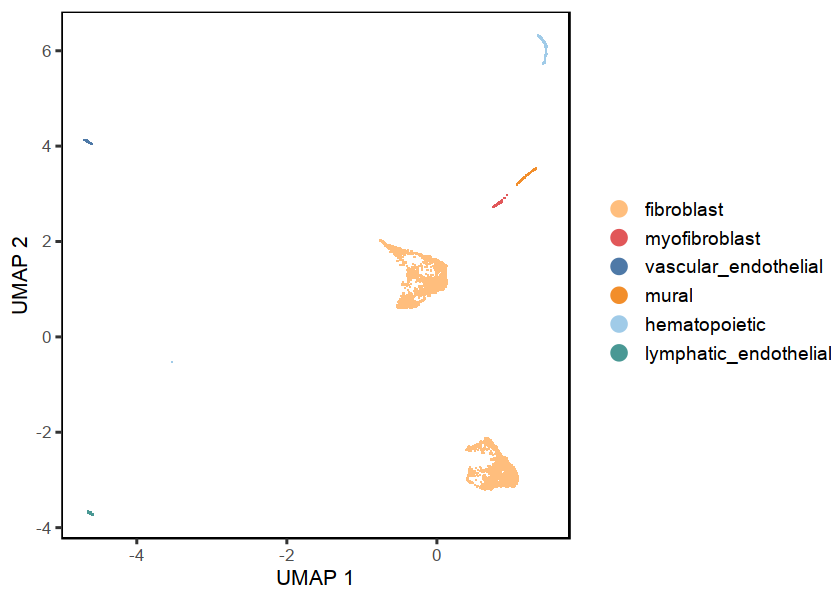

In [20]:
fig.size(5, 7)
# idx <- which(!is.na(gut_mm$meta_data$lineage))
p1 <- do_scatter(
    gut_mm$umap_after, gut_mm$meta_data, 'lineage',
    base_size = 10, pt_size = 5,
#     do_raster = TRUE, w = 2, h = 1.5,
    do_labels = FALSE, no_guides = FALSE,
    palette_use = palette_global[unique(gut_mm$meta_data$lineage)]
) + 
    theme(legend.title = element_blank())

p1 


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


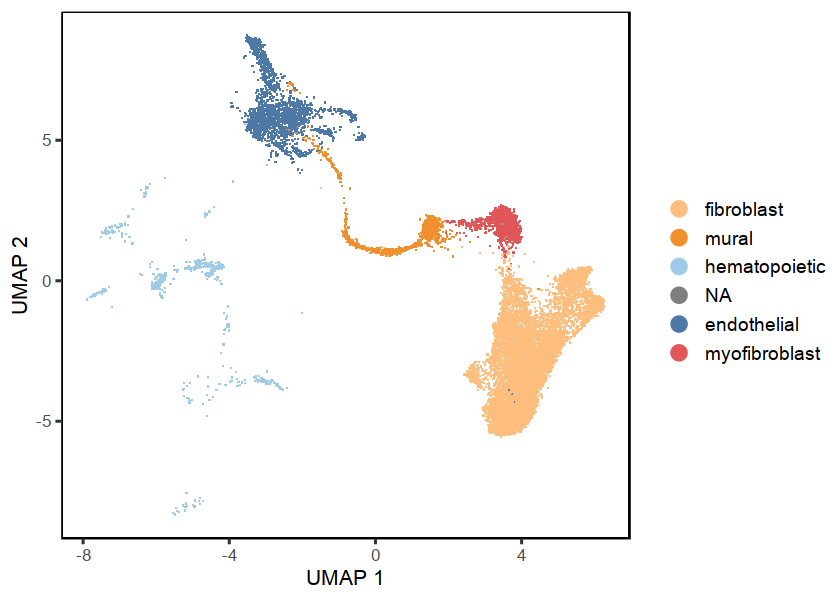

In [21]:
fig.size(5, 7)

idx_lung <- which(lung_mm$meta_data$lineage != 'UNKNOWN')

p2 <- do_scatter(
    lung_mm$umap_after[idx_lung, ], lung_mm$meta_data[idx_lung, ], 'lineage',
    base_size = 10, pt_size = 5,
#     do_raster = TRUE, w = 2, h = 1.5,
    do_labels = FALSE, no_guides = FALSE,
    palette_use = palette_global[unique(lung_mm$meta_data$lineage)]
) +  
    theme(legend.title = element_blank())

p2 


FIX THIS LATER: get synovium UMAP from NOTCH paper analyses

In [22]:
.x <- readRDS('/data/srlab2/ik936/NOTCH/data/cache/mouse.rds')
syn_mm$umap_after <- syn_mm$meta_data %>% 
    left_join(
        .x$meta_data %>% 
            dplyr::select(CellID = cell_id) %>% 
            cbind(data.table(.x$umap_harmony)) 
    ) %>% 
    dplyr::select(X1 = V1, X2 = V2) %>% 
    as('matrix')


syn_mm$meta_data <- syn_mm$meta_data %>% 
    dplyr::mutate(lineage = case_when(
        cell_type %in% c('sublining', 'lining', 'intermediate', 'perivascular') ~ 'fibroblast',
        cell_type %in% c('arterial', 'venous', 'endothelial', 'vascular_endothelial') ~ 'vascular_endothelial', 
        cell_type %in% c('bcell', 'tcell', 'myeloid', 'neutrophil') ~ 'hematopoietic',
        cell_type %in% c('pericyte_VSMC', 'mural') ~ 'mural', 
        cell_type %in% c('chondrocytes') ~ 'proliferating', 
        TRUE ~ cell_type
    ))


Joining, by = "CellID"



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


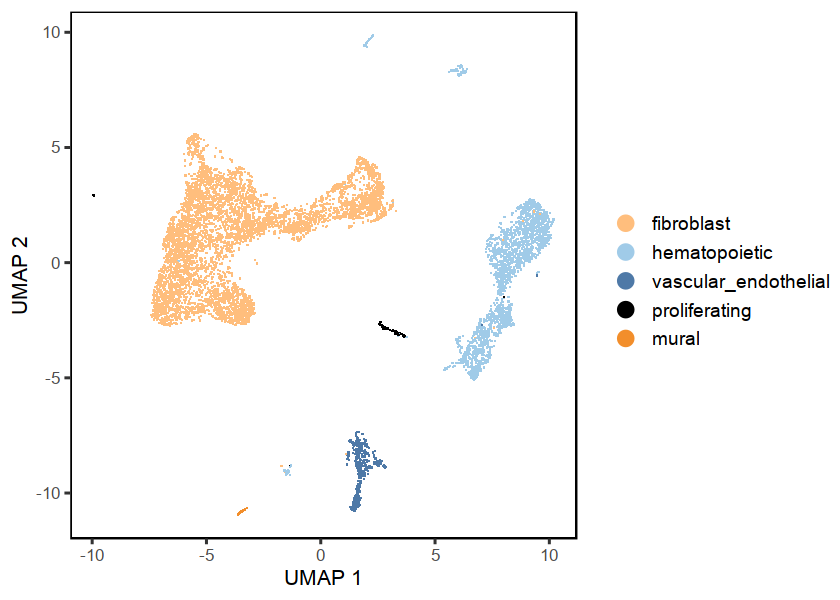

In [23]:
fig.size(5, 7)

idx_syn <- which(syn_mm$meta_data$lineage != 'UNKNOWN')

p3 <- do_scatter(
    syn_mm$umap_after[idx_syn, ], syn_mm$meta_data[idx_syn, ], 'lineage',
    base_size = 10, pt_size = 5,
#     do_raster = TRUE, w = 2, h = 1.5,
    do_labels = FALSE, no_guides = FALSE,
    palette_use = palette_global[unique(syn_mm$meta_data$lineage)]
) +  
    theme(legend.title = element_blank())

p3 


In [24]:
umap_df <- list(
    syn_mm$umap_after[idx_syn, ],
    syn_mm_cia$umap_after,
    lung_mm$umap_after[idx_lung, ],
    gut_mm$umap_after
) %>% 
    purrr::reduce(rbind)


In [25]:
meta_df <- list(
    S_sta = syn_mm$meta_data[idx_syn, c('lineage'), drop = FALSE],
    S_cia = syn_mm_cia$meta_data[, 'lineage', drop = FALSE],
    L = lung_mm$meta_data[idx_lung, c('lineage'), drop = FALSE],
    G = gut_mm$meta_data[, c('lineage'), drop = FALSE]
) %>% 
    bind_rows(.id = 'Tissue')


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Ignoring unknown parameters: width, height”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


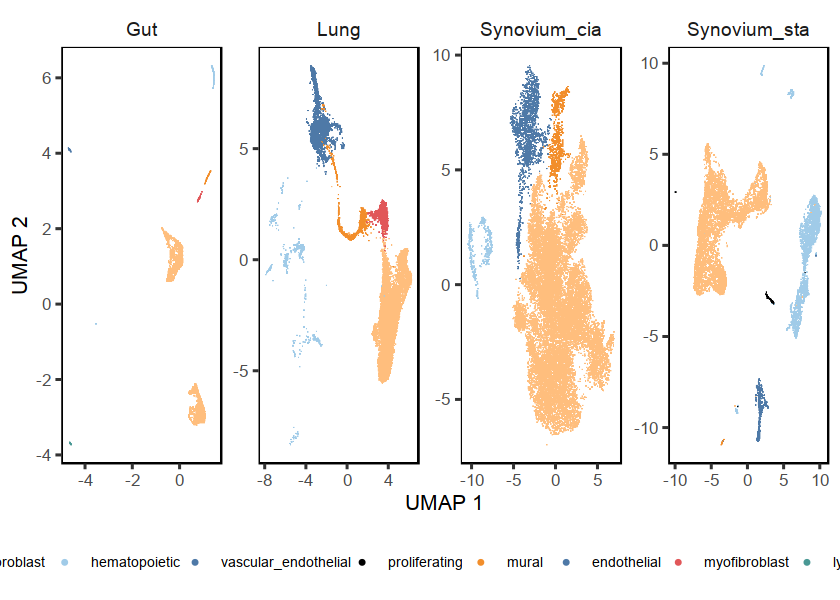

In [26]:
fig.size(5, 7)
# idx <- which(!is.na(gut_mm$meta_data$lineage))
p1 <- do_scatter(
    umap_df, 
    meta_df %>% dplyr::mutate(
        Tissue = case_when(
            Tissue == 'G' ~ 'Gut',
            Tissue == 'S_sta' ~ 'Synovium_sta',
            Tissue == 'S_cia' ~ 'Synovium_cia',
            Tissue == 'L' ~ 'Lung'
        )
    ), 
    'lineage',
    base_size = 10, pt_size = 5,
    do_raster = TRUE, w = 2, h = 1.5,
    do_labels = FALSE, no_guides = FALSE,
    palette_use = palette_global[unique(meta_df$lineage)]
) + 
    facet_wrap(~Tissue, scales = 'free', nrow = 1) + 
    theme(
        legend.title = element_blank(),
        legend.text = element_text(size = 8),
        legend.position = 'bottom'
    ) + 
    guides(color = guide_legend(
        override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 1),
        nrow = 1
    ), alpha = FALSE) + 
    NULL

p1 


## Plot genes

In [27]:
genes_plot <- c('Ptprc', 'Col1a1', 'Mcam', 'Mki67', 'Cdh5', 'Lyve1', 'Myh11')
exprs_df <- list(
    scaleData(syn_mm$exprs_norm)[genes_plot, idx_syn],
    scaleData(syn_mm_cia$exprs_norm)[genes_plot, ],
    scaleData(lung_mm$exprs_norm)[genes_plot, idx_lung],
    scaleData(gut_mm$exprs_norm)[genes_plot, ]
) %>% 
    purrr::reduce(cbind2)


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


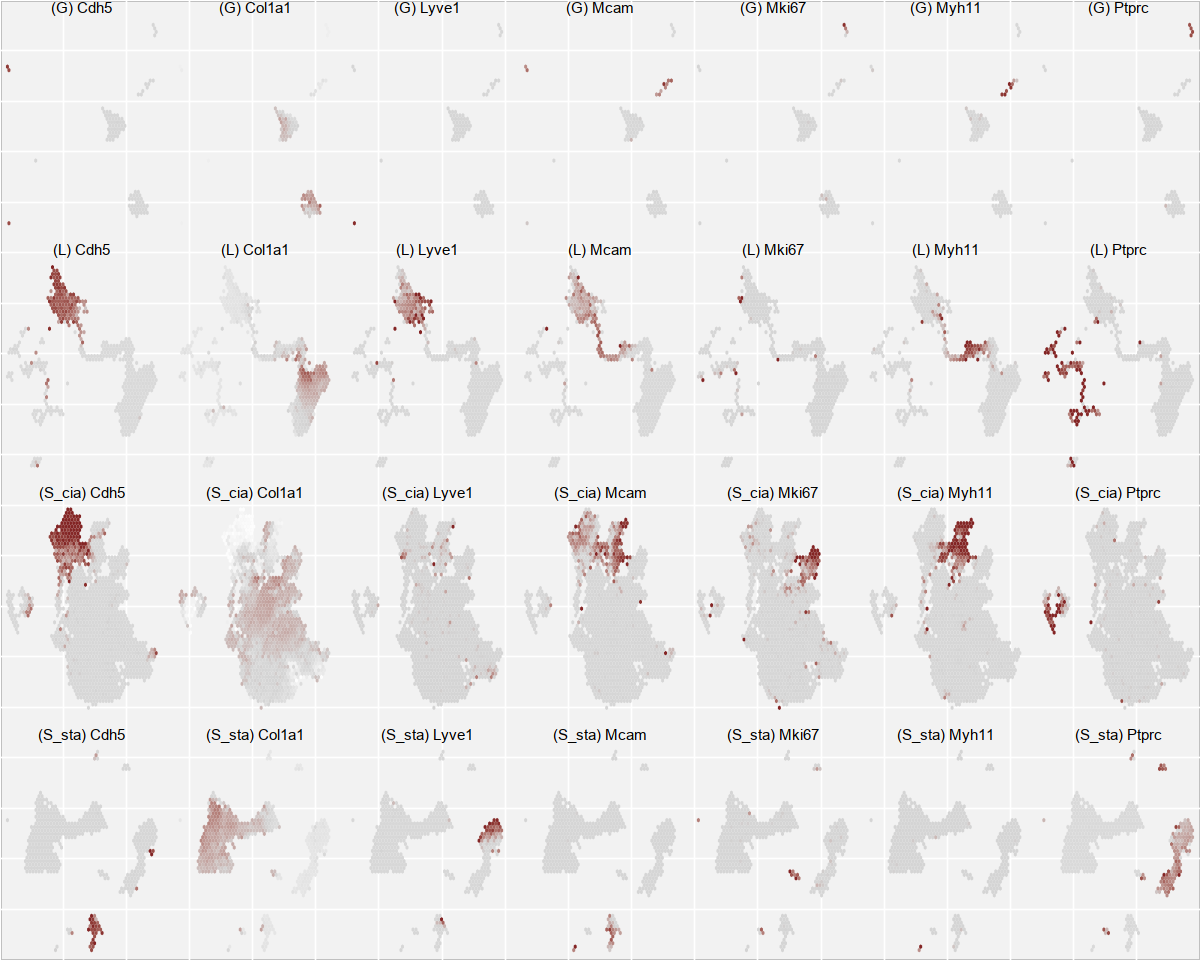

In [28]:
fig.size(8, 10)
p6 <- data.frame(umap_df) %>% 
    cbind(meta_df) %>% 
    cbind(t(exprs_df)) %>% 
    tidyr::gather(gene, value, Ptprc:Myh11) %>% 
    dplyr::mutate(value = pmin(value, 3)) %>% 
    dplyr::mutate(Label = glue('({Tissue}) {gene}')) %>% 
    ggplot(aes(X1, X2, z = value)) + 
        stat_summary_hex(bins = 50) + 
#         facet_grid(. ~ gene) + 
        scale_fill_gradient2(mid = 'lightgrey', low = 'white', high = muted('red'), midpoint = 0) + 
        labs(x = 'UMAP 1', y = 'UMAP 2') + 
        guides(fill = FALSE) + 
#         scale_x_continuous(breaks = c(-4, 0, 4)) + 
        facet_wrap(~Label, scales = 'free', nrow = 4) + 
        theme_void() + 
#         facet_wrap(Tissue~gene, scales = 'free', nrow = 3) + 
        NULL

p6 <- remove_strip_box(p6)
plot(p6)


# Barplots

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


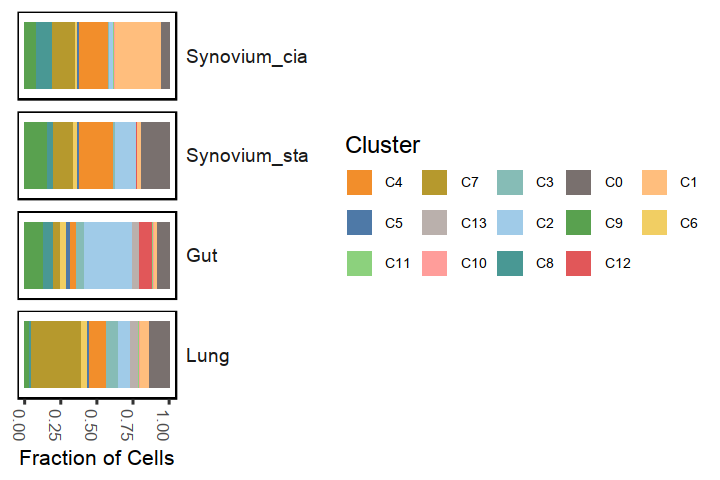

In [29]:
fig.size(4, 6)
p_bar <- obj$meta_data %>% 
    with(table(Tissue, Cluster)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('Synovium_cia', 'Synovium_sta', 'Gut', 'Lung'))) %>% 
    ggplot(aes(Tissue, N, fill = Cluster)) + 
        geom_bar(stat = 'identity', position = position_fill()) + 
#         scale_fill_tableau('Tableau 20') + 
        scale_fill_manual(values = palette_global[unique(obj$meta_data$Cluster)]) + 
        coord_flip() + 
        labs(y = 'Fraction of Cells') + 
        facet_grid(Tissue~., scales = 'free', space = 'free') + 
#         scale_y_continuous(labels = scales::percent) + 
#         guides(fill = FALSE) + 
        theme(
            strip.text.y = element_text(angle = 0, hjust = 0),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            axis.title.y = element_blank(),
#             legend.position = 'bottom',
            axis.text.x = element_text(angle = -90, hjust = 1),
            legend.text = element_text(size = 8)
        ) + 
#         guides(fill = guide_legend(nrow=3,byrow=TRUE)) + 
        guides(fill = guide_legend(
            override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 1),
            nrow = 3, byrow = TRUE
        ), alpha = FALSE) + 
        NULL

p_bar


# Conservation (heatmap) 

In [30]:
df_mm <- obj$effects_hs %>% 
    dplyr::mutate(Cluster = gsub('C', 'mm_', Cluster)) %>% 
    dplyr::mutate(Cluster = paste0(Tissue, '_', Cluster)) %>% 
    dplyr::select(Cluster, zscore, feature) %>% 
    tidyr::spread(Cluster, zscore) %>% 
    tibble::column_to_rownames('feature')

## Compare to tissue-specific effects
df_hs <- effects_ref_nested %>%
    subset(!Tissue %in% c('SalivaryGland')) %>% 
    dplyr::mutate(Cluster = paste0(Tissue, '_', Cluster)) %>% 
    dplyr::select(Cluster, zscore, feature) %>% 
    tidyr::spread(Cluster, zscore) %>% 
    tibble::column_to_rownames('feature')

genes_use <- intersect(rownames(df_mm), rownames(df_hs))
cormat <- cor(df_mm[genes_use, ], df_hs[genes_use, ])
o_row <- order(as.integer(gsub('.*?(\\d+)', '\\1', rownames(cormat))))
o_column <- order(as.integer(gsub('.*?(\\d+)', '\\1', colnames(cormat))))
cormat <- cormat[o_row, o_column]


In [31]:
anno_row <- data.frame(
    Cluster = gsub('^(.*?)_(.*?)_(\\d+)', '\\3', rownames(cormat)),
    Tissue = gsub('^(.*?)_(.*?)_(\\d+)', '\\1', rownames(cormat))
) %>% 
    dplyr::mutate(Tissue = gsub('_cia|_sta', '', Tissue))

anno_col <- data.frame(
    Cluster = gsub('^(.*?)_(\\d+)', '\\2', colnames(cormat)),
    Tissue = gsub('^(.*?)_(\\d+)', '\\1', colnames(cormat))
)


Loading required namespace: jpeg



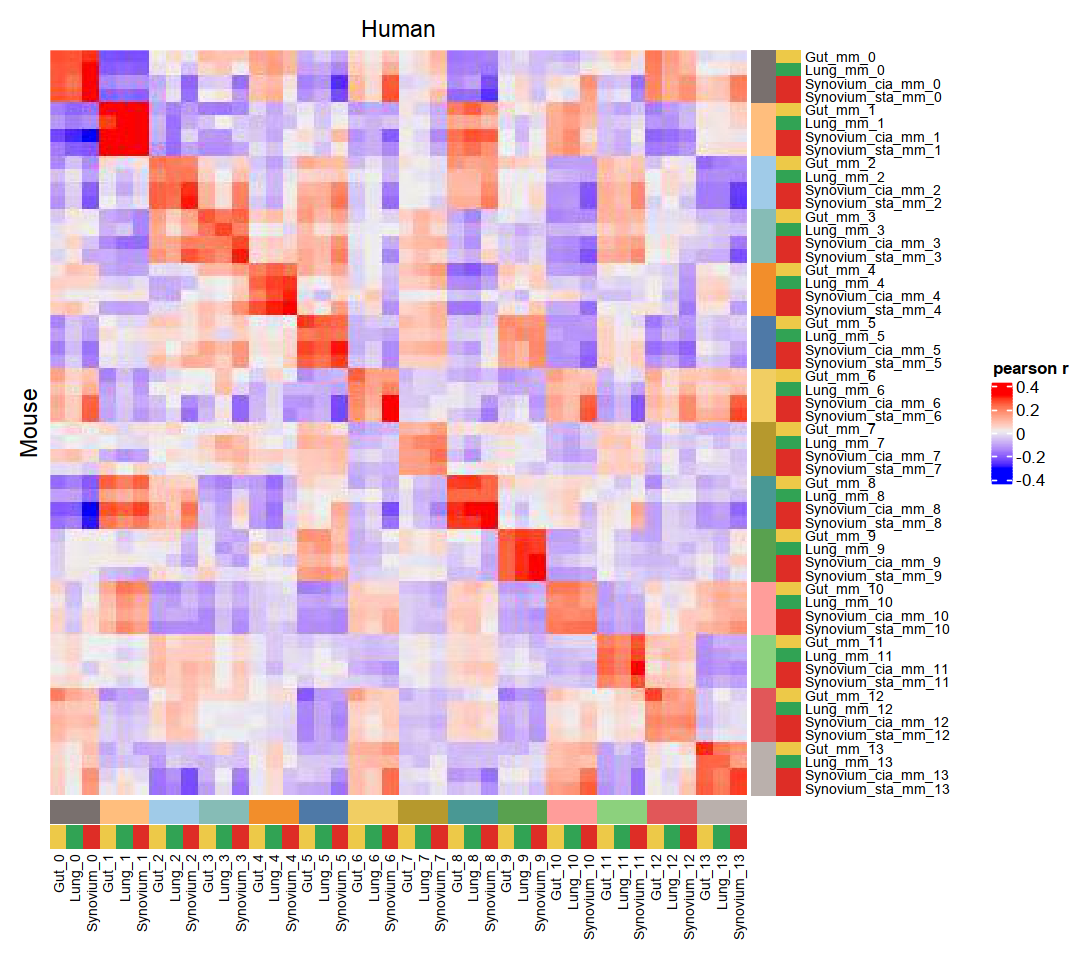

In [32]:
fig.size(8, 9)

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 8))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))

h1 <- Heatmap(
    cormat,
    name = 'pearson r',
    cluster_rows = FALSE, cluster_columns = FALSE,
    row_title = 'Mouse', column_title = 'Human',
    bottom_annotation = columnAnnotation(
        df = anno_col,
        show_legend = FALSE,
        col = palette_heatmap,
        show_annotation_name = FALSE
    ),
    right_annotation = rowAnnotation(
        df = anno_row,
        show_legend = FALSE,
        col = palette_heatmap,
        show_annotation_name = FALSE
    ),
    use_raster = TRUE, raster_device = "CairoJPEG"
)

p7 <- grid.grabExpr(draw(h1, padding = unit(c(2, 2, 2, 8), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings

wrap_elements(p7)


# MASC forest 

## NEW

In [33]:
mm_masc <- readRDS('/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/masc.rds')
hs_masc <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/masc.rds')
hs_masc$Cluster <- paste0('C', hs_masc$Cluster)
hs_masc$fdr <- p.adjust(hs_masc$pvalue, 'BH')

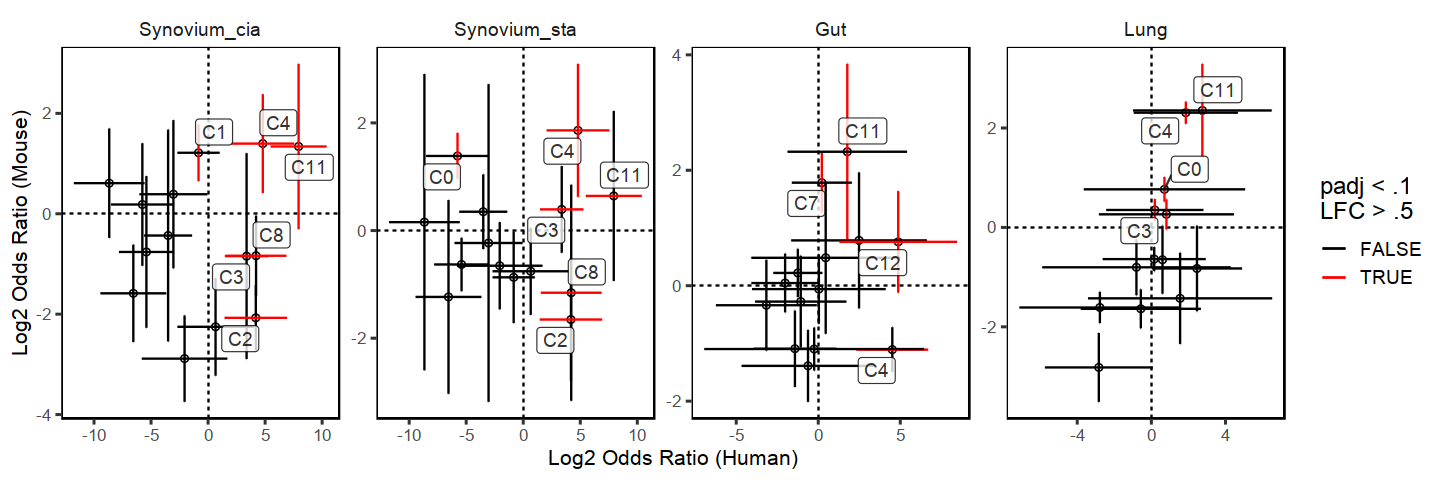

In [34]:
fig.size(4, 12)
p8 <- mm_masc %>% 
    dplyr::mutate(Tissue2 = Tissue) %>% 
    dplyr::mutate(Tissue = gsub('_cia|_sta', '', Tissue)) %>% 
    inner_join(hs_masc, by = c('Cluster', 'Tissue'), suffix = c('_mm', '_hs')) %>% 
    dplyr::mutate(Tissue2 = factor(Tissue2, c('Synovium_cia', 'Synovium_sta', 'Gut', 'Lung'))) %>% 

# inner_join(mm$masc, hs$masc, by = c('Cluster', 'Tissue'), suffix = c('_mm', '_hs')) %>% 
    subset(sigma_hs < 10) %>% ## NOTE THIS IN THE FIGURE LEGEND! 
    ggplot(aes(beta_hs, beta_mm)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_point(shape = 21) + 
        geom_errorbar(aes(
            ymin = beta_mm - 1.96*sigma_mm, 
            ymax = beta_mm + 1.96*sigma_mm,
            color = fdr_mm < .2 & beta_mm > 0.2
        )) + 
        geom_errorbarh(aes(
            xmin = beta_hs - 1.96*sigma_hs, 
            xmax = beta_hs + 1.96*sigma_hs,
            color = fdr_hs < .1 & beta_hs > 1
        )) + 
        geom_label_repel(
            data = . %>% subset((fdr_mm < .05 & beta_mm > 0.2) | (fdr_hs < .1 & beta_hs > 1)),
            aes(label = Cluster),
            size = 4, alpha = .8
        ) + 
        labs(
            x = 'Log2 Odds Ratio (Human)',
            y = 'Log2 Odds Ratio (Mouse)',
            color = 'padj < .1\nLFC > .5'
        ) + 
        facet_wrap(~Tissue2, scales = 'free', nrow=1) +
#         guides(color = FALSE) + 
        scale_color_manual(values = c('black', 'red')) + 
        NULL

p8


# Panel

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


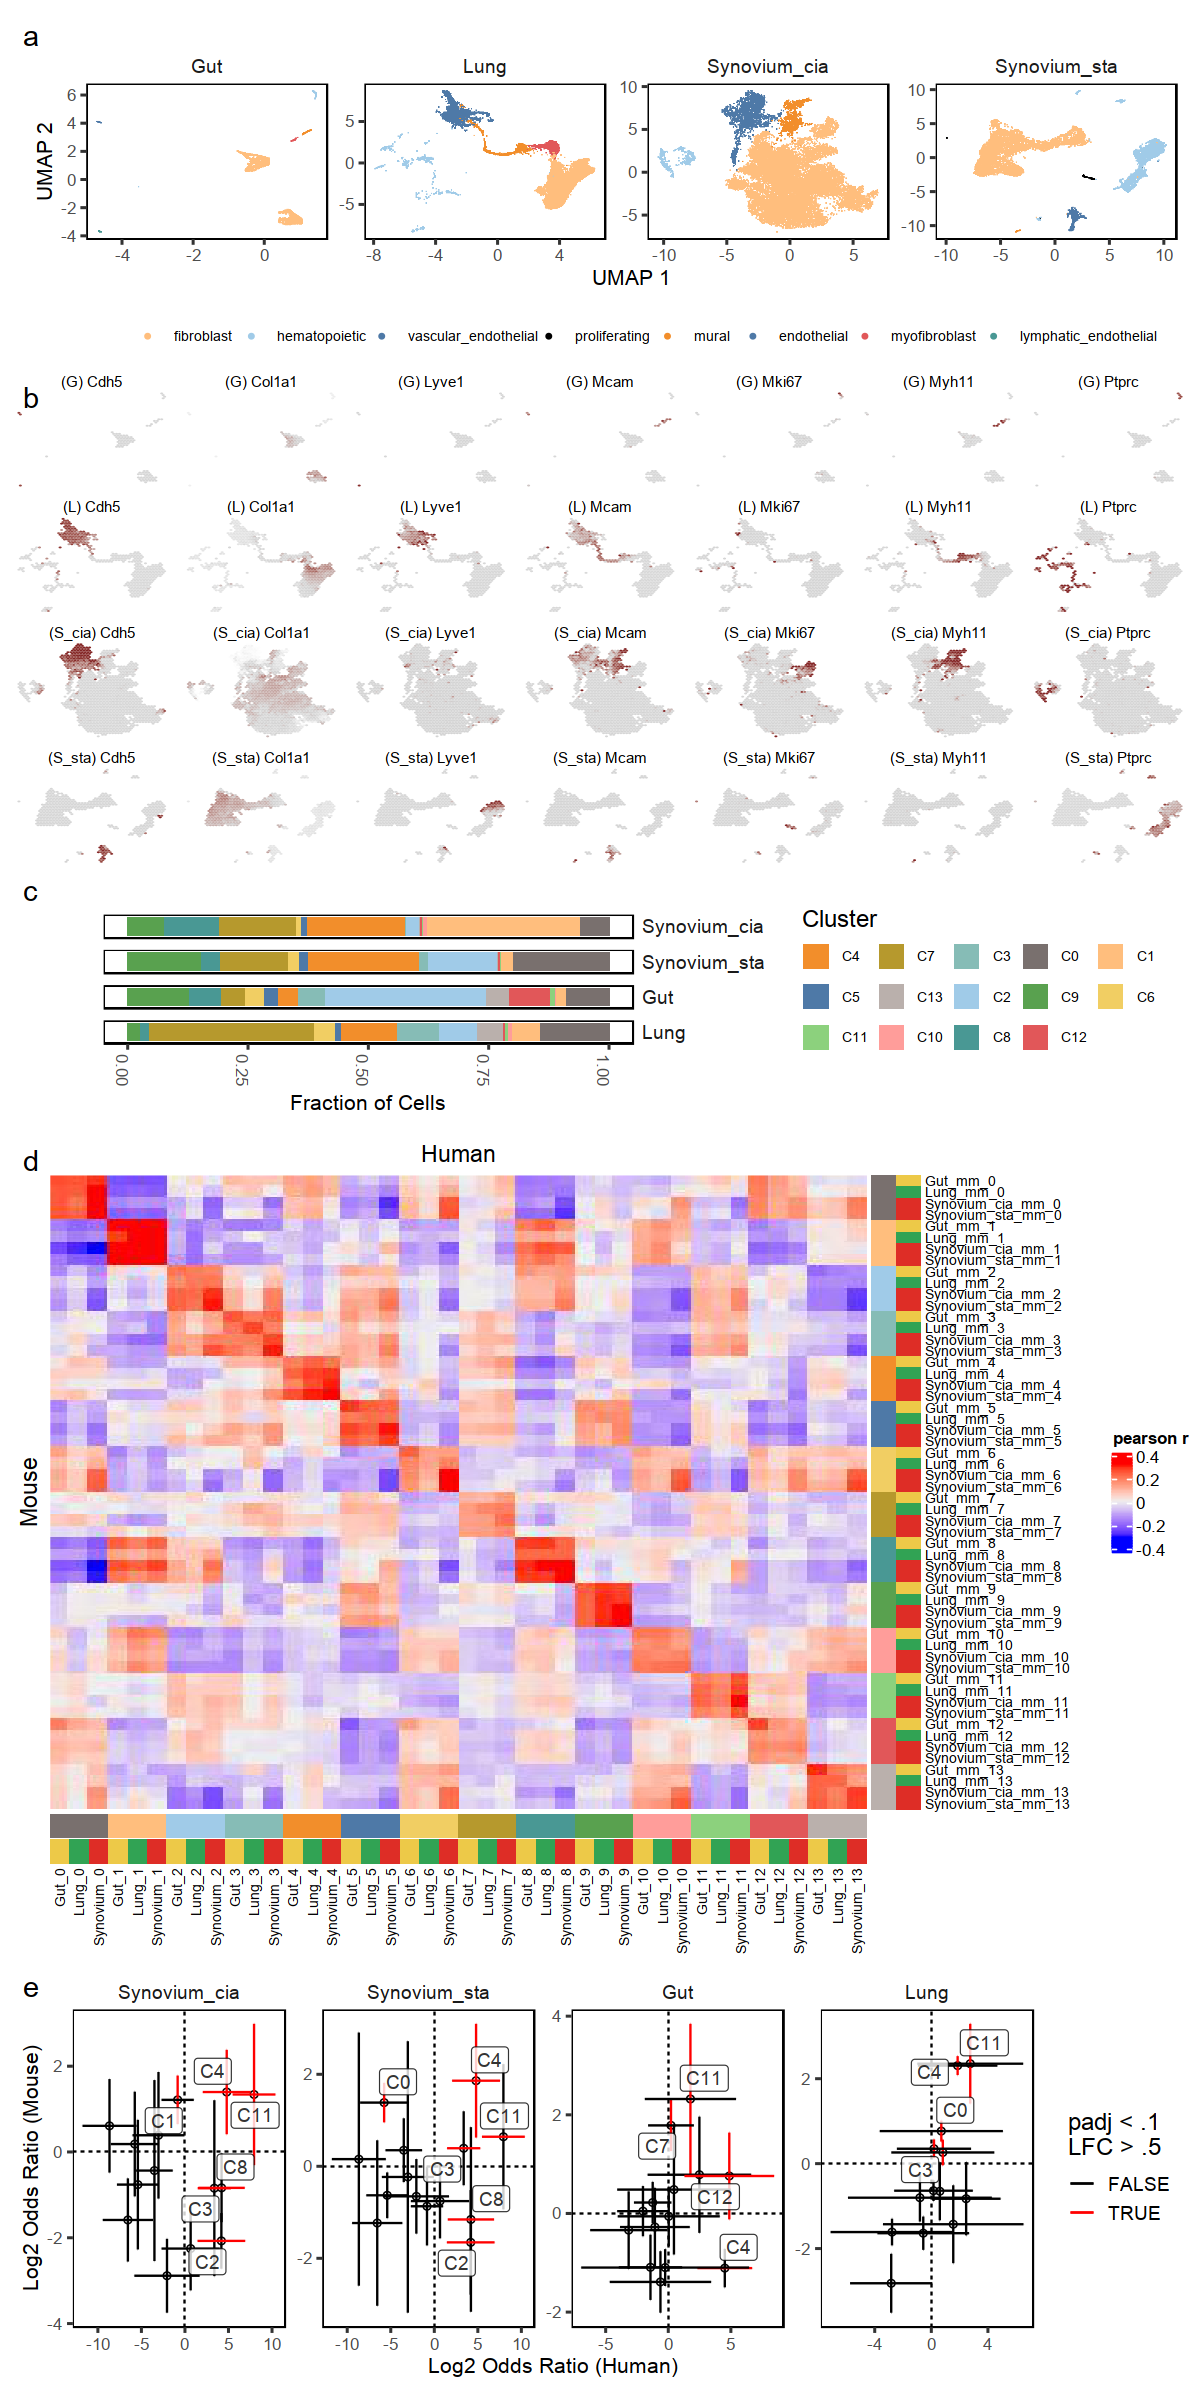

In [35]:
fig.size(20, 10)
(
    (
#         wrap_elements(p1)
        p1
    ) / (
        wrap_elements(full = p6)
    ) / 
    (
        wrap_elements(p_bar)
    ) / 
    (
#         (p_bar | wrap_elements(p7)) + plot_layout(widths = c(1, 4))
        wrap_elements(full = p7)
    ) / 
    wrap_elements(full = p8)
) + 
    plot_layout(heights = c(.7, 2, 1, 3.5, 1.7)) + 
    plot_annotation(tag_levels = 'a')


In [36]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/SuppFigure10.pdf', 
#     filename = '/data/srla2b/ik936/Roche/manuscript/figures/mouse/panels.pdf', 
    units = 'in', device = 'pdf', 
    height = 20, width = 10,
    useDingbats = FALSE
)
